In [1]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mlxtend.plotting import scatterplotmatrix, heatmap
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import (
    LinearRegression,
    RANSACRegressor,
    Lasso,
    Ridge,
    ElasticNet,
)
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.model_selection import train_test_split
from ML_With_Pytorch_Scikit_learn_Sebastian.ch09.linear_regression import (
    LinearRegressionGD,
)

columns = [
    "Overall Qual",
    "Overall Cond",
    "Gr Liv Area",
    "Central Air",
    "Total Bsmt SF",
    "SalePrice",
]
df = pd.read_csv(
    "http://jse.amstat.org/v19n3/decock/AmesHousing.txt", sep="\t", usecols=columns
)
df.head(), df.shape
df["Central Air"] = df["Central Air"].map({"N": 0, "Y": 1})
df.isnull().sum()
# Have two ways to deal with missing data: 1 remove it, 2 guess it by mean
df = df.fillna(df.mean())
df.isnull().sum()

Overall Qual     0
Overall Cond     0
Total Bsmt SF    0
Central Air      0
Gr Liv Area      0
SalePrice        0
dtype: int64

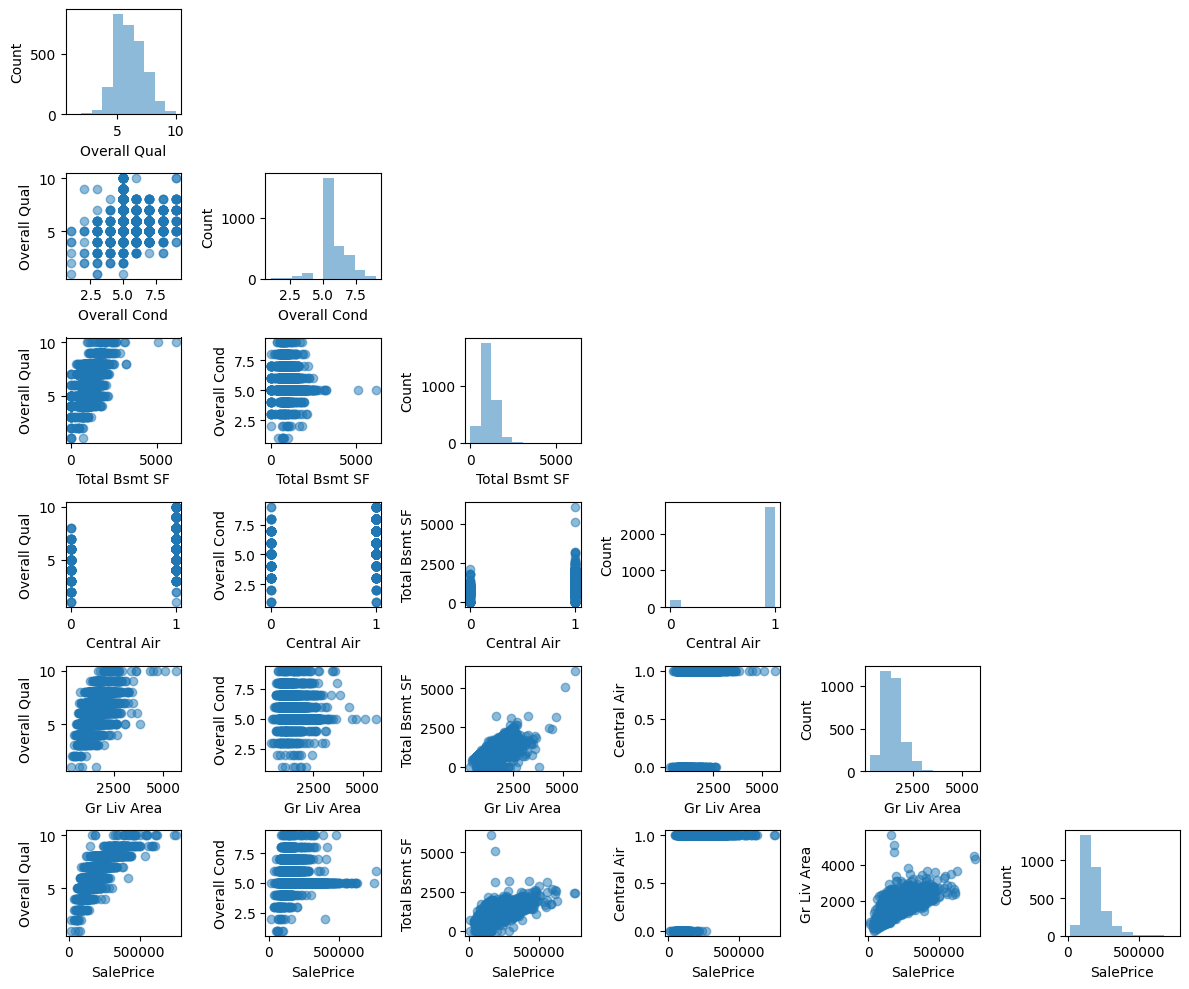

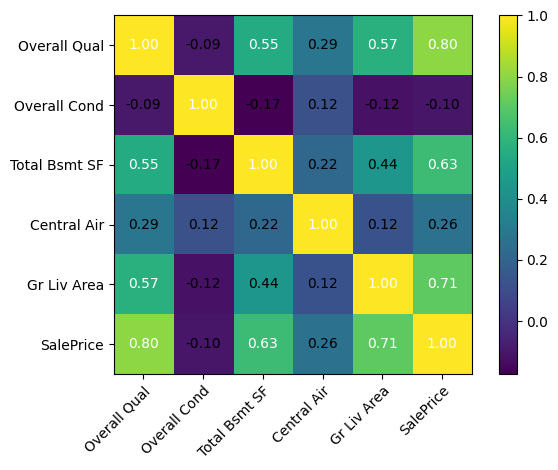

In [2]:
scatterplotmatrix(df.values, figsize=(12, 10), names=df.columns, alpha=0.5)
plt.tight_layout()
# --- correlation matrix
cm = np.corrcoef(df.values.T)
hm = heatmap(cm, row_names=df.columns, column_names=df.columns)
plt.tight_layout()
plt.show()

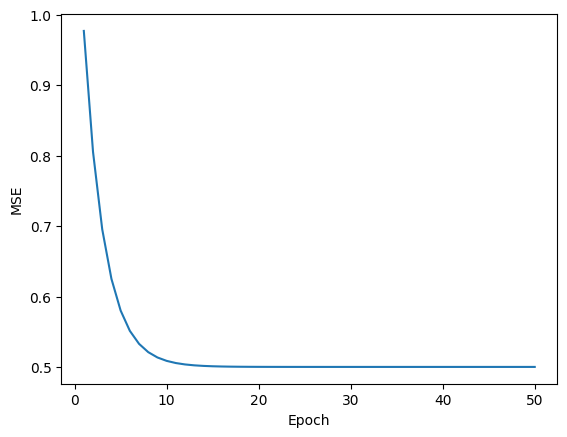

In [3]:
X = df[["Gr Liv Area"]].values
y = df["SalePrice"].values
sc_x = StandardScaler()
sc_y = StandardScaler()
X_std = sc_x.fit_transform(X)
y_std = sc_y.fit_transform(y[:, np.newaxis]).flatten()
lr = LinearRegressionGD(eta=0.1)
lr.fit(X_std, y_std)

plt.plot(range(1, lr.n_iter + 1), lr.losses_)
plt.ylabel("MSE")
plt.xlabel("Epoch")
plt.show()

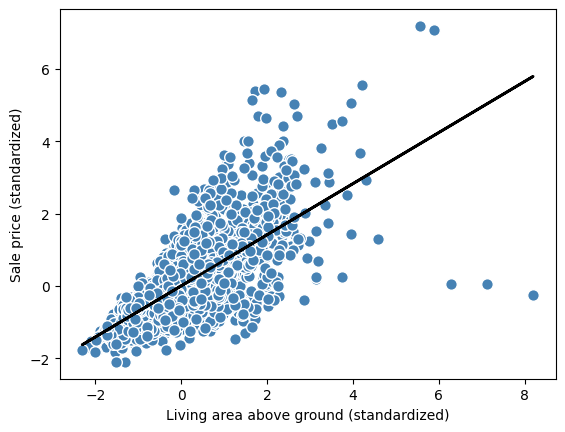

Normalized [1.39880731]
Sale price: $292523.08


In [4]:
def lin_regplot(X, y, model):
    plt.scatter(X, y, c="steelblue", edgecolor="white", s=70)
    plt.plot(X, model.predict(X), color="black", lw=2)


lin_regplot(X_std, y_std, lr)
plt.xlabel("Living area above ground (standardized)")
plt.ylabel("Sale price (standardized)")
plt.show()
# Scale back the price to dollar Value $
feature_std = sc_x.transform([[2500]])
target_std = lr.predict(feature_std)
print("Normalized", target_std)
target_reverted = sc_y.inverse_transform(target_std.reshape(-1, 1))
print(f"Sale price: ${target_reverted.flatten()[0]:.2f}")

Slope: 111.694]
Intercept: 13289.634]


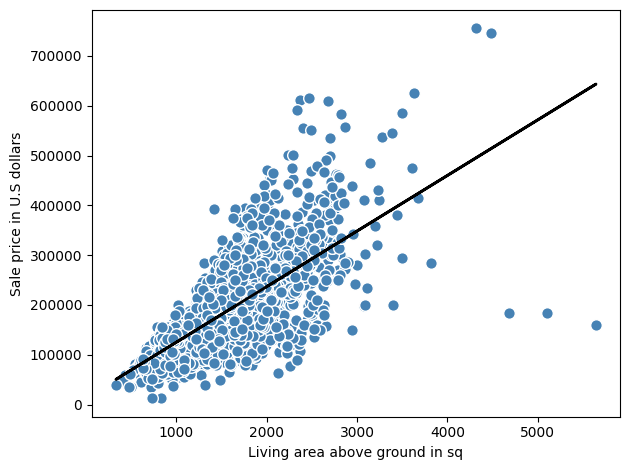

In [5]:
# LinearRegression with scikit-learn without normalization applied
slr = LinearRegression()
slr.fit(X, y)
y_pred = slr.predict(X)
print(f"Slope: {slr.coef_[0]:.3f}]")
print(f"Intercept: {slr.intercept_:.3f}]")

lin_regplot(X, y, slr)
plt.xlabel("Living area above ground in sq")
plt.ylabel("Sale price in U.S dollars")
plt.tight_layout()
# Both plots are quite same
plt.show()

Using RANSAC, we reduced the potential effect of the outliers in this dataset, but we don’t know whether
this approach will have a positive effect on the predictive performance for unseen data or not.

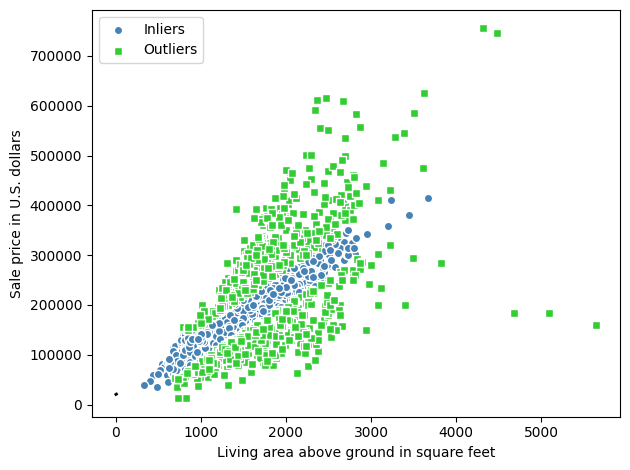

In [6]:
def mean_absolute_deviation(data):
    return np.mean(np.abs(data - np.mean(data)))


mean_absolute_deviation(y)

ransac = RANSACRegressor(
    LinearRegression(),
    max_trials=100,
    min_samples=0.95,
    residual_threshold=None,
    random_state=123,
)
ransac.fit(X, y)
inlier_mask = ransac.inlier_mask_
outlier_mask = np.logical_not(inlier_mask)
line_X = np.arange(3, 10, 1)
line_y_ransac = ransac.predict(line_X[:, np.newaxis])
plt.scatter(
    X[inlier_mask],
    y[inlier_mask],
    c="steelblue",
    edgecolor="white",
    marker="o",
    label="Inliers",
)
plt.scatter(
    X[outlier_mask],
    y[outlier_mask],
    c="limegreen",
    edgecolor="white",
    marker="s",
    label="Outliers",
)
plt.plot(line_X, line_y_ransac, color="black", lw=2)
plt.xlabel("Living area above ground in square feet")
plt.ylabel("Sale price in U.S. dollars")
plt.legend(loc="upper left")
plt.tight_layout()
plt.show()

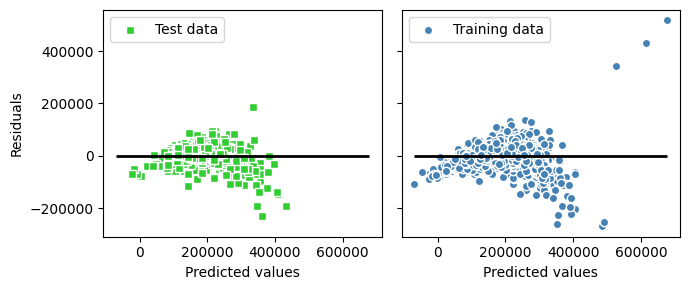

In [7]:
target = "SalePrice"
features = df.columns[df.columns != target]
X = df[features].values
y = df[target].values

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=123
)
slr = LinearRegression()
slr.fit(X_train, y_train)
y_train_pred = slr.predict(X_train)
y_test_pred = slr.predict(X_test)

x_max = np.max([np.max(y_train_pred), np.max(y_test_pred)])
x_min = np.min([np.min(y_train_pred), np.min(y_test_pred)])
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(7, 3), sharey=True)
ax1.scatter(
    y_test_pred,
    y_test_pred - y_test,
    c="limegreen",
    marker="s",
    edgecolor="white",
    label="Test data",
)
ax2.scatter(
    y_train_pred,
    y_train_pred - y_train,
    c="steelblue",
    marker="o",
    edgecolor="white",
    label="Training data",
)
ax1.set_ylabel("Residuals")
for ax in (ax1, ax2):
    ax.set_xlabel("Predicted values")
    ax.legend(loc="upper left")
    ax.hlines(y=0, xmin=x_min - 100, xmax=x_max + 100, color="black", lw=2)
plt.tight_layout()
plt.show()

In [8]:
# Metrics
mse_train = mean_squared_error(y_train, y_train_pred)
mse_test = mean_squared_error(y_test, y_test_pred)
print(f"MSE train: {mse_train:.2f}")
print(f"MSE test: {mse_test:.2f}")
mse_train = mean_absolute_error(y_train, y_train_pred)
mse_test = mean_absolute_error(y_test, y_test_pred)
print(f"MAE train: {mse_train:.2f}")
print(f"MAE test: {mse_test:.2f}")
# Approximately $25k error on average

train_r2 = r2_score(y_train, y_train_pred)
test_r2 = r2_score(y_test, y_test_pred)
print(f"R ^ 2 Train: {train_r2:.3f}, test: {test_r2:.3f}")

alpha = 1.0
ridge = Ridge(alpha=alpha)
lasso = Lasso(alpha=alpha)
elanet = ElasticNet(alpha=alpha, l1_ratio=0.5)

MSE train: 1625014901.92
MSE test: 1219054382.05
MAE train: 26257.96
MAE test: 24890.63
R ^ 2 Train: 0.752, test: 0.797


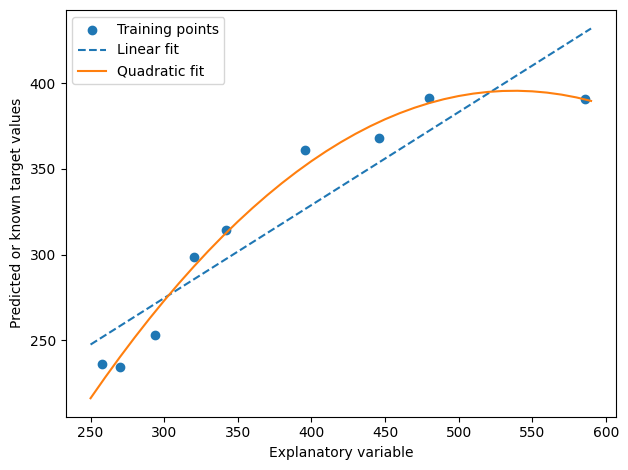

Training MSE linear: 539.094, quadratic: 60.807
Training R^2 linear: 0.854, quadratic: 0.984


In [9]:
X = np.array([258.0, 270.0, 294.0, 320.0, 342.0, 396.0, 446.0, 480.0, 586.0])[
    :, np.newaxis
]
y = np.array([236.4, 234.4, 252.8, 298.6, 314.2, 360.8, 368.0, 391.2, 390.8])
lr = LinearRegression()
pr = LinearRegression()
quadratic = PolynomialFeatures(degree=2)
X_quad = quadratic.fit_transform(X)
# Simple linear
lr.fit(X, y)
X_fit = np.arange(250, 600, 10)[:, np.newaxis]
y_lin_fit = lr.predict(X_fit)

# Quadratic linear
pr.fit(X_quad, y)
y_quad_fit = pr.predict(quadratic.fit_transform(X_fit))
plt.scatter(X, y, label="Training points")
plt.plot(X_fit, y_lin_fit, label="Linear fit", linestyle="--")
plt.plot(X_fit, y_quad_fit, label="Quadratic fit")
plt.xlabel("Explanatory variable")
plt.ylabel("Predicted or known target values")
plt.legend(loc="upper left")
plt.tight_layout()
plt.show()
# Metrics
y_lin_pred = lr.predict(X)
y_quad_pred = pr.predict(X_quad)
mse_lin = mean_squared_error(y, y_lin_pred)
mse_quad = mean_squared_error(y, y_quad_pred)
print(f"Training MSE linear: {mse_lin:.3f}, quadratic: {mse_quad:.3f}")
r2_lin = r2_score(y, y_lin_pred)
r2_quad = r2_score(y, y_quad_pred)
print(f"Training R^2 linear: {r2_lin:.3f}, quadratic: {r2_quad:.3f}")

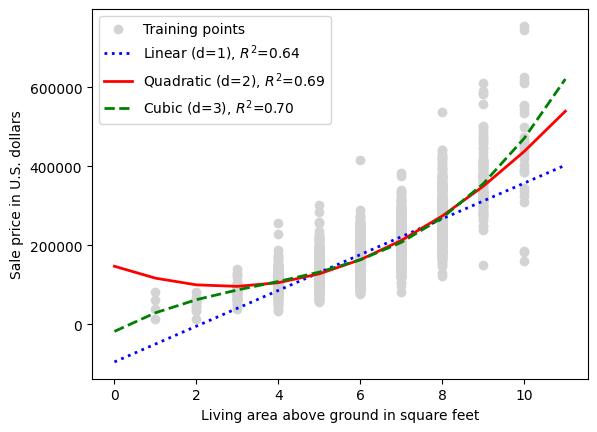

In [10]:
#  removing the three outliers with a living area greater than 4,000 square feet, so that these outliers don’t skew our regression
# No difference with polynomial feature captured on these two features
# X = df[["Gr Liv Area"]].values
# y = df["SalePrice"].values
# X = X[(df["Gr Liv Area"] < 4000)]
# y = y[(df["Gr Liv Area"] < 4000)]

# But with these two there is a difference in R^2 score
X = df[['Overall Qual']].values
y = df['SalePrice'].values
regr = LinearRegression()

quadratic = PolynomialFeatures(degree=2)
cubic = PolynomialFeatures(degree=3)
X_quad = quadratic.fit_transform(X)
X_cubic = cubic.fit_transform(X)

X_fit = np.arange(X.min() - 1, X.max() + 2, 1)[:, np.newaxis]
regr = regr.fit(X, y)
y_lin_fit = regr.predict(X_fit)
linear_r2 = r2_score(y, regr.predict(X))
regr = regr.fit(X_quad, y)
y_quad_fit = regr.predict(quadratic.fit_transform(X_fit))
quadratic_r2 = r2_score(y, regr.predict(X_quad))
regr = regr.fit(X_cubic, y)
y_cubic_fit = regr.predict(cubic.fit_transform(X_fit))
cubic_r2 = r2_score(y, regr.predict(X_cubic))

plt.scatter(X, y, label="Training points", color="lightgray")
plt.plot(
    X_fit,
    y_lin_fit,
    label=f"Linear (d=1), $R^2$={linear_r2:.2f}",
    color="blue",
    lw=2,
    linestyle=":",
)
plt.plot(
    X_fit,
    y_quad_fit,
    label=f"Quadratic (d=2), $R^2$={quadratic_r2:.2f}",
    color="red",
    lw=2,
    linestyle="-",
)
plt.plot(
    X_fit,
    y_cubic_fit,
    label=f"Cubic (d=3), $R^2$={cubic_r2:.2f}",
    color="green",
    lw=2,
    linestyle="--",
)
plt.xlabel("Living area above ground in square feet")
plt.ylabel("Sale price in U.S. dollars")
plt.legend(loc="upper left")
plt.show(); # No difference in R^2



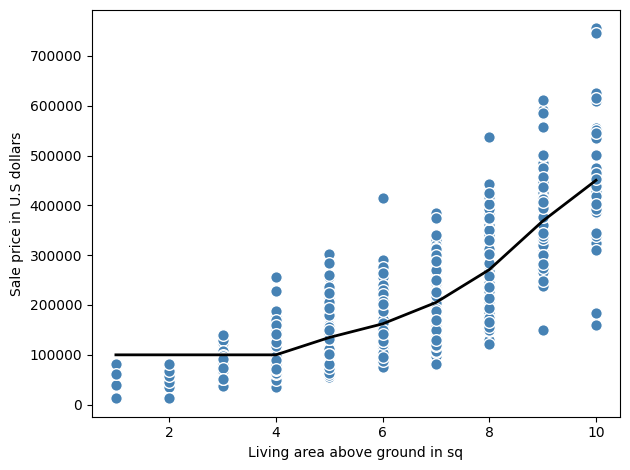

In [11]:
# Using Decision tree in regression
# X = df[['Gr Liv Area']].values
X = df[['Overall Qual']].values
y = df['SalePrice'].values

tree = DecisionTreeRegressor(max_depth=4)
tree.fit(X,y)
sort_idx = X.flatten().argsort()
lin_regplot(X[sort_idx], y[sort_idx], tree)
plt.xlabel("Living area above ground in sq")
plt.ylabel("Sale price in U.S dollars")
plt.tight_layout()
plt.show()

MAE train: 8368.48
MAE test: 21480.80
R^2 train: 0.98
R^2 test: 0.83


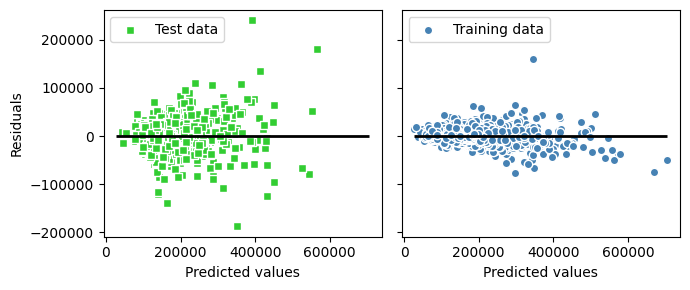

In [12]:
# Using Random Forest
features = df.columns[df.columns != target]
X = df[features].values
y = df[target].values

forest = RandomForestRegressor(n_estimators=1000, criterion='squared_error', random_state=1, n_jobs=-1)
forest.fit(X_train, y_train)
y_train_pred = forest.predict(X_train)
y_test_pred = forest.predict(X_test)
mae_train = mean_absolute_error(y_train, y_train_pred)
mae_test = mean_absolute_error(y_test, y_test_pred)
print(f'MAE train: {mae_train:.2f}')
print(f'MAE test: {mae_test:.2f}')
r2_train = r2_score(y_train, y_train_pred)
r2_test =r2_score(y_test, y_test_pred)
print(f'R^2 train: {r2_train:.2f}')
print(f'R^2 test: {r2_test:.2f}')

x_max = np.max([np.max(y_train_pred), np.max(y_test_pred)])
x_min = np.min([np.min(y_train_pred), np.min(y_test_pred)])
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(7, 3), sharey=True)
ax1.scatter(
    y_test_pred,
    y_test_pred - y_test,
    c="limegreen",
    marker="s",
    edgecolor="white",
    label="Test data",
)
ax2.scatter(
    y_train_pred,
    y_train_pred - y_train,
    c="steelblue",
    marker="o",
    edgecolor="white",
    label="Training data",
)
ax1.set_ylabel("Residuals")
for ax in (ax1, ax2):
    ax.set_xlabel("Predicted values")
    ax.legend(loc="upper left")
    ax.hlines(y=0, xmin=x_min - 100, xmax=x_max + 100, color="black", lw=2)
plt.tight_layout()
plt.show()